In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile
with ZipFile('Data/2021_stat.zip', 'r') as zipObj:
  zipObj.extractall('Data')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MIE479/Deliverable_4')
!ls '/content/drive/MyDrive/MIE479/Deliverable_4'

 2020-2021	       linear_svm_2022.pkl	     thunder_rbf_svm_2021.pkl
 linear_svm_2019.pkl  'Linear SVM Model.ipynb'	    'Thunder SVM Models.ipynb'
 linear_svm_2020.pkl  'Polynomial SVM Model.ipynb'
 linear_svm_2021.pkl   thunder_poly2_svm_2021.pkl


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [ ]:
file_name = '/content/Data/2021_stat.csv'
table = pd.read_csv(file_name, low_memory=False).dropna()

table = table[[
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
    'FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'NUM_UNIT',
    'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'MI_PCT', 'DLQ_30_FLAG', 'DLQ_90_FLAG',
    'Ongoing', 'Current_DLQ', 'Prepaid_Matured', 'Deed_In_Lieu']]

table['BAD'] = None
table.loc[(table['DLQ_90_FLAG'] == 1) | (table['Deed_In_Lieu'] == 1), 'BAD'] = 1
table.loc[(table['Ongoing'] == 1) & (table['DLQ_30_FLAG'] == 0), 'BAD'] = 0
table = table.dropna(subset=['BAD'])
table['BAD'] = table['BAD'].astype(int)

n_row, n_col = table.shape
n_dlq_90 = sum(table['DLQ_90_FLAG'])
n_fc = sum(table['Deed_In_Lieu'])
print(f"Number of rows: {n_row}")
print(f"Number of columns: {n_col}")
print(f"Percentage of 90-day delinquency: {round(n_dlq_90 / n_row * 100, 2)} %")
print(f"Percentage of foreclosure: {round(n_fc / n_row * 100, 2)} %")
print("The total number of NA is ", sum(table.isna().sum()))

<ipython-input-4-40b7bc001823>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['BAD'] = None


Number of rows: 3896571
Number of columns: 23
Percentage of 90-day delinquency: 1.45 %
Percentage of foreclosure: 0.01 %
The total number of NA is  0


<ipython-input-4-40b7bc001823>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['BAD'] = table['BAD'].astype(int)


In [ ]:
sampled = table.sample(n=1000000, random_state=999)

X = sampled.drop(columns=['DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ',
                        'Prepaid_Matured', 'Deed_In_Lieu', 'BAD'])
y = sampled['BAD']

num_col = ['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
           'NUM_UNIT', 'MI_PCT']
cat_col = ['FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase',
           'OCC_Principal', 'OCC_Second', 'OCC_Investor']

scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
X[cat_col] = scaler.fit_transform(X[cat_col])
X = pd.concat([X[num_col], X[cat_col]], axis=1)

X

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,MI_PCT,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,OCC_Principal,OCC_Second,OCC_Investor
4013967,0.228364,1.778544,0.617349,1.466056,-0.924422,0.149930,-0.186446,-0.109372,2.371990,-0.428862,-0.569595,-0.892776,1.486681,0.300424,-0.180549,-0.232333
308387,0.822763,-0.413773,0.617349,0.506934,-0.924422,1.255486,-0.256902,-0.109372,-0.468448,-0.428862,-0.569595,1.120102,-0.672639,0.300424,-0.180549,-0.232333
3254368,0.822763,0.168562,-0.146399,0.986495,-0.924422,-0.955625,0.048407,-0.109372,1.898583,-0.428862,-0.569595,1.120102,-0.672639,0.300424,-0.180549,-0.232333
2197392,0.204588,-0.461730,-0.910147,-0.185765,-0.924422,-1.056130,0.189318,-0.109372,-0.468448,-0.428862,1.755634,-0.892776,-0.672639,0.300424,-0.180549,-0.232333
429610,-2.173008,-0.715216,-1.673894,-1.411310,1.009778,0.350941,1.034789,-0.109372,-0.468448,-0.428862,-0.569595,1.120102,-0.672639,0.300424,-0.180549,-0.232333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904829,-0.366035,-0.776875,-1.673894,-0.452188,-0.924422,0.752961,-1.149344,-0.109372,-0.468448,-0.428862,-0.569595,1.120102,-0.672639,0.300424,-0.180549,-0.232333
2162758,-0.675123,-0.311008,-1.673894,-0.239050,1.009778,-1.257140,1.293127,-0.109372,-0.468448,-0.428862,1.755634,-0.892776,-0.672639,0.300424,-0.180549,-0.232333
443541,-0.960434,-0.907044,-1.673894,-0.931749,-0.924422,-0.252090,0.893877,-0.109372,-0.468448,-0.428862,1.755634,-0.892776,-0.672639,-3.328630,-0.180549,4.304174
271281,-0.056947,-0.276753,-0.910147,-2.263862,-0.924422,1.657506,1.011304,-0.109372,-0.468448,-0.428862,-0.569595,1.120102,-0.672639,0.300424,-0.180549,-0.232333


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

poly_svm = SVC(kernel='poly', degree=2, random_state=999, class_weight='balanced', verbose=1)
poly_svm.fit(X_train, y_train)

y_pred = poly_svm.predict(X_test)
y_pred_prob = poly_svm.decision_function(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc_prob = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {round(accuracy, 4)}")
print(f"AUC-ROC Predict: {round(roc_auc, 4)}")
print(f"AUC-ROC Decision function: {round(roc_auc_prob, 4)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

with open('/content/drive/MyDrive/MIE479/Deliverable_4/poly2_svm_2021.pkl', 'wb') as file:
    pickle.dump(poly_svm, file)

[LibSVM]Accuracy: 0.7345
AUC-ROC Predict: 0.7199
AUC-ROC Decision function: 0.7681
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.85    147802
           1       0.04      0.70      0.07      2198

    accuracy                           0.73    150000
   macro avg       0.52      0.72      0.46    150000
weighted avg       0.98      0.73      0.83    150000



In [ ]:
print(round(y_test.sum() / len(y_test), 4))
print(round(y_pred.sum() / len(y_pred), 4))
poly_vectors = poly_svm.support_vectors_
print(len(poly_vectors))

0.0147
0.2715
221201


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

rbf_svm = SVC(kernel='rbf', class_weight='balanced', gamma='scale', random_state=999, verbose=1)
rbf_svm.fit(X_train, y_train)

y_pred = rbf_svm.predict(X_test)
y_pred_prob = rbf_svm.decision_function(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc_prob = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {round(accuracy, 4)}")
print(f"AUC-ROC Predict: {round(roc_auc, 4)}")
print(f"AUC-ROC Decision function: {round(roc_auc_prob, 4)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

with open('/content/drive/MyDrive/MIE479/Deliverable_4/sk_rbf_svm_2021.pkl', 'wb') as file:
    pickle.dump(rbf_svm, file)

[LibSVM]Accuracy: 0.7301
AUC-ROC Predict: 0.7501
AUC-ROC Decision function: 0.8043
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    295679
           1       0.04      0.77      0.08      4321

    accuracy                           0.73    300000
   macro avg       0.52      0.75      0.46    300000
weighted avg       0.98      0.73      0.83    300000



In [ ]:
print(round(y_test.sum() / len(y_test), 4))
print(round(y_pred.sum() / len(y_pred), 4))
rbf_vectors = rbf_svm.support_vectors_
print(len(rbf_vectors))

0.0144
0.2777
363427


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

linear_svm = LinearSVC(random_state=999, max_iter=1000000, class_weight='balanced')
linear_svm.fit(X_train, y_train)

y_pred_linear = linear_svm.predict(X_test)
y_pred_prob_linear = linear_svm.decision_function(X_test)

accuracy = accuracy_score(y_test, y_pred_linear)
roc_auc = roc_auc_score(y_test, y_pred_linear)
roc_auc_prob = roc_auc_score(y_test, y_pred_prob_linear)

print(f"Accuracy: {round(accuracy, 4)}")
print(f"AUC-ROC Predict: {round(roc_auc, 4)}")
print(f"AUC-ROC Decision function: {round(roc_auc_prob, 4)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_linear))

Accuracy: 0.731
AUC-ROC Predict: 0.7502
AUC-ROC Decision function: 0.8239
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    295679
           1       0.04      0.77      0.08      4321

    accuracy                           0.73    300000
   macro avg       0.52      0.75      0.46    300000
weighted avg       0.98      0.73      0.83    300000



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import make_classification

y_pred_prob_rbf = y_pred_prob
y_pred_prob_poly = poly_svm.decision_function(X_test)

fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_prob_linear)
auc_linear = roc_auc_score(y_test, y_pred_prob_linear)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_prob_rbf)
auc_score = roc_auc_score(y_test, y_pred_prob_rbf)

fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_prob_poly)
auc_score = roc_auc_score(y_test, y_pred_prob_poly)

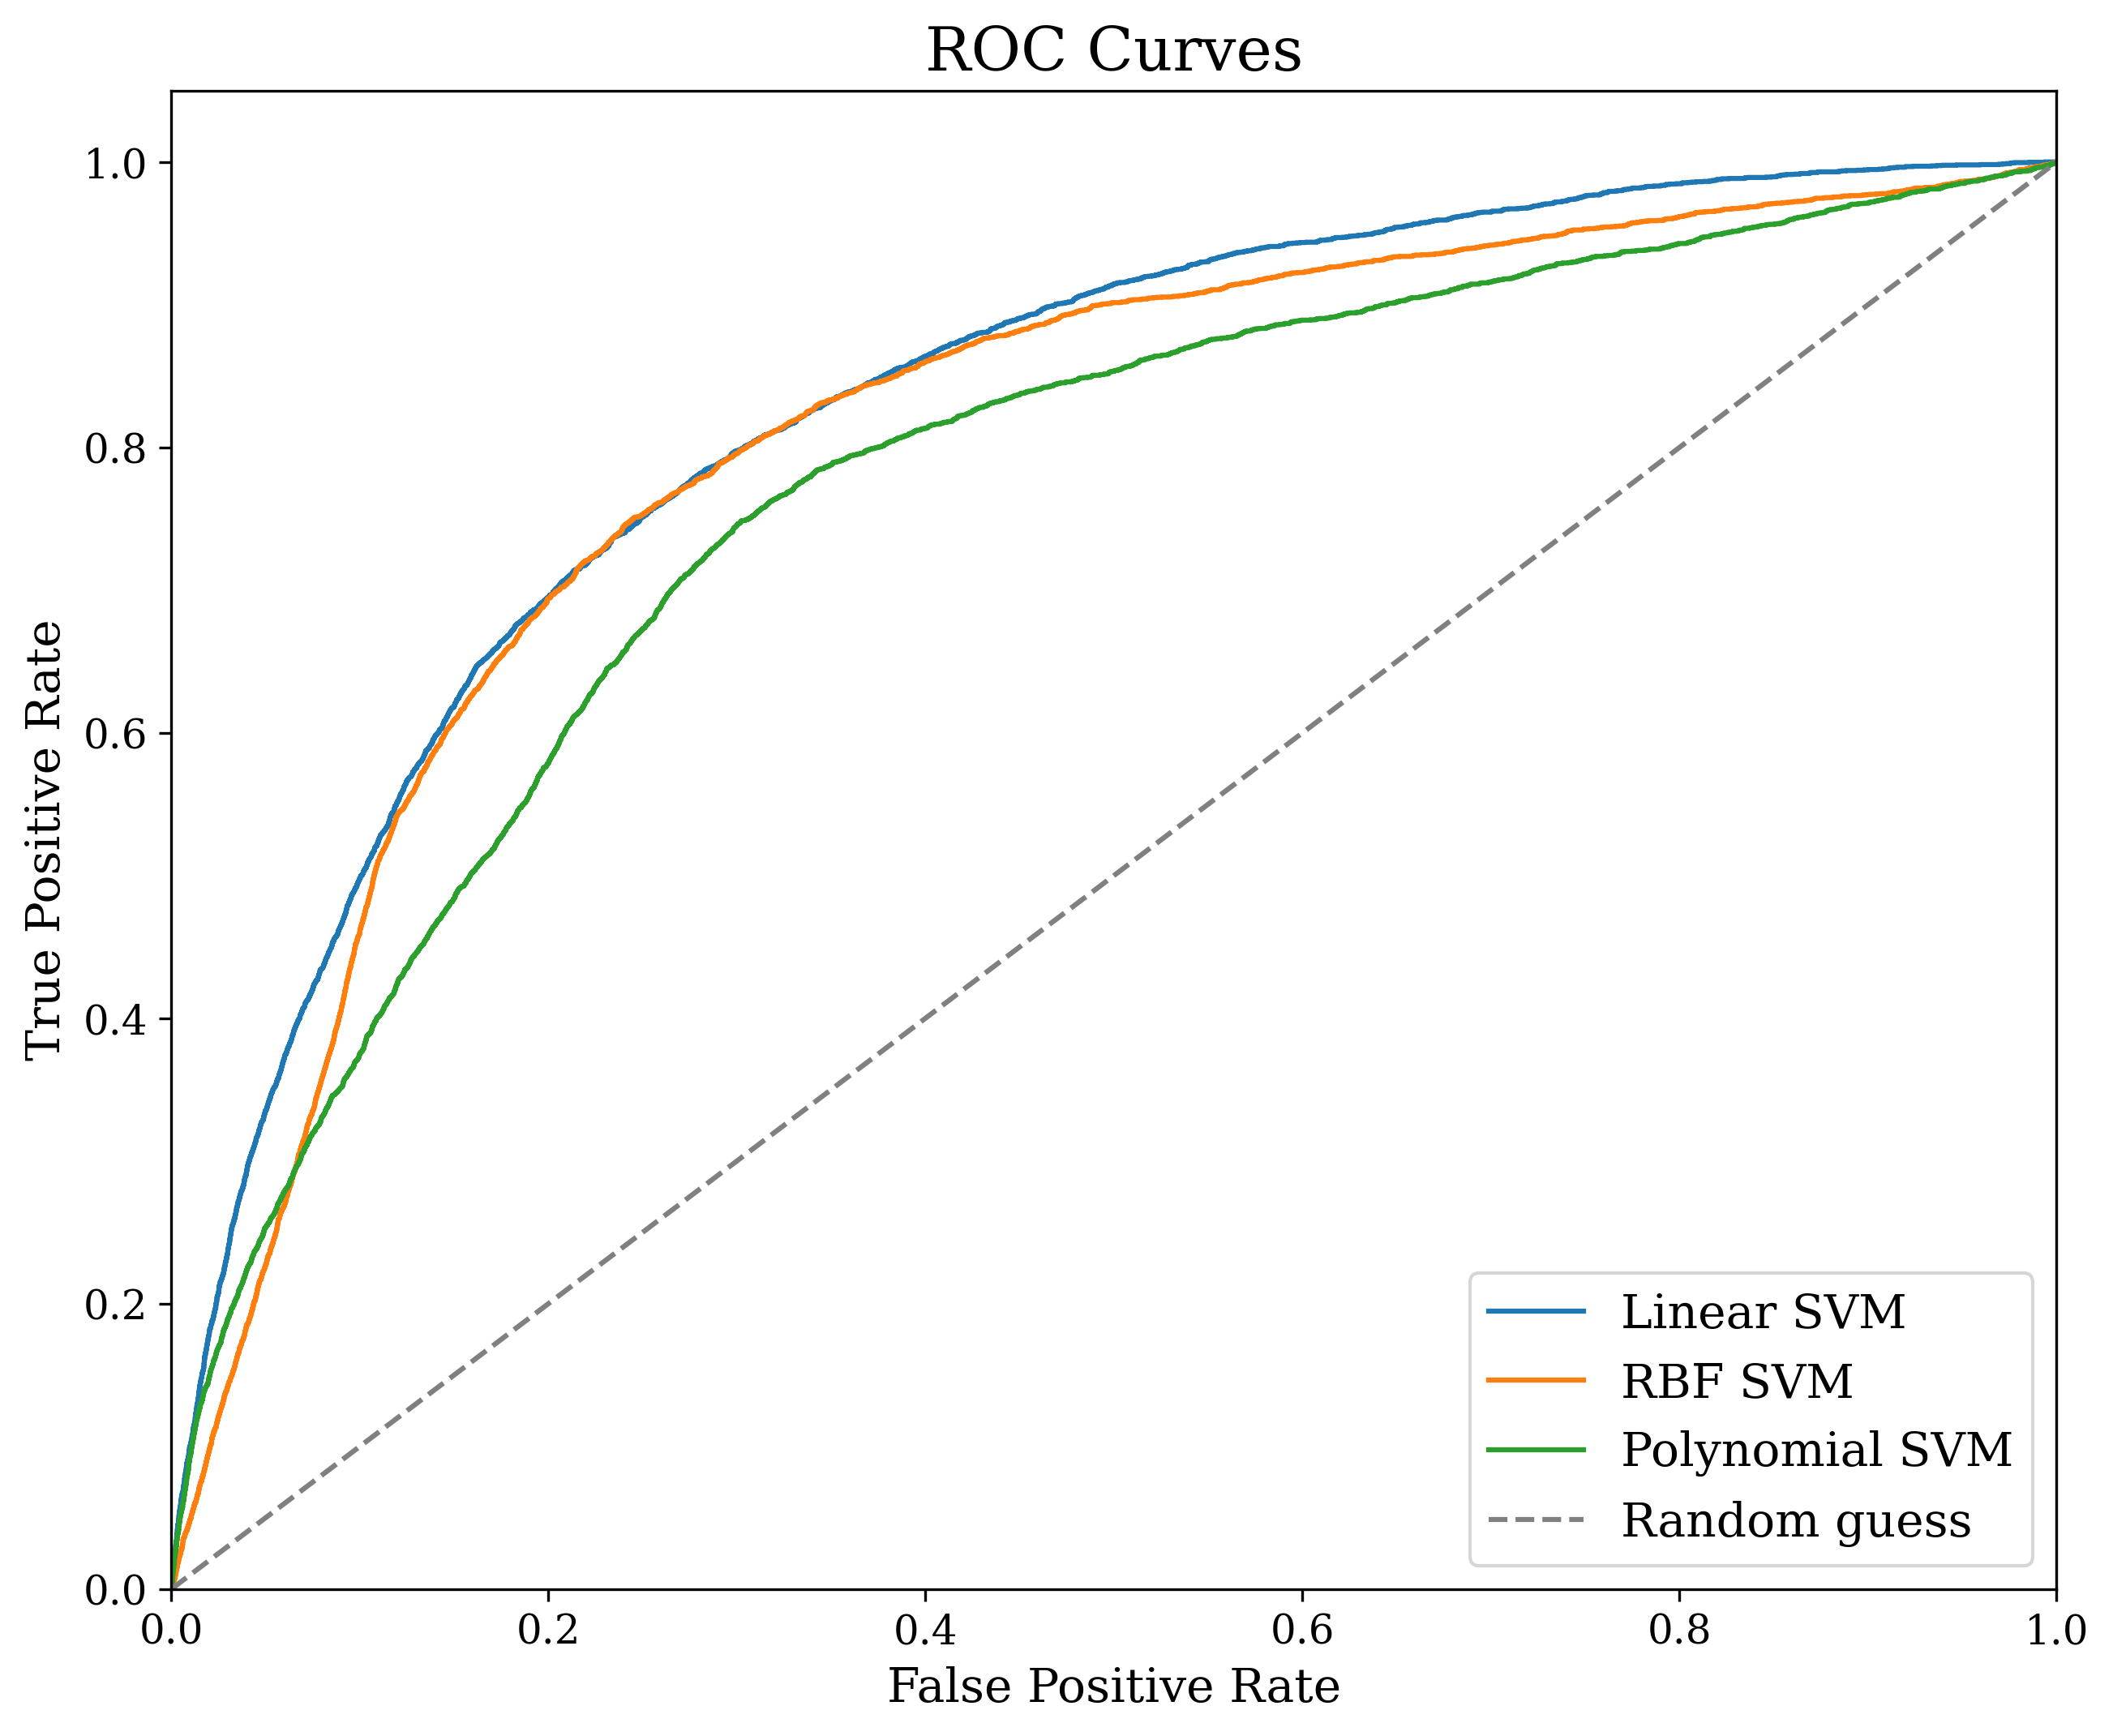

In [ ]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.size': 14,  # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 14,  # Label font size
    'xtick.labelsize': 12,  # X-axis tick font size
    'ytick.labelsize': 12,  # Y-axis tick font size
    'legend.fontsize': 14,  # Legend font size
    'figure.dpi': 300,  # Higher resolution for reports
    'savefig.dpi': 300,  # Resolution for saved figures
})

plt.plot(fpr_linear, tpr_linear, label="Linear SVM")
plt.plot(fpr_rbf, tpr_rbf, label="RBF SVM")
plt.plot(fpr_poly, tpr_poly, label="Polynomial SVM")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random guess")

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.show()

In [ ]:
print(y_pred_prob_linear)
print(y_pred_prob_rbf)
print(y_pred_prob_poly)

[-1.16278329 -0.62217304 -0.62051249 ... -0.25716199 -0.52167438
  0.42820943]
[-1.29715703 -1.31058428 -2.16722414 ... -0.57512382 -1.07009443
  1.13587474]
[-0.50657097 -1.08033351 -1.40967169 ... -0.98324947 -0.97542221
  0.31654126]


In [ ]:
pred = y_pred_prob_linear > 0
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.size': 12,  # General font size
    'axes.titlesize': 14,  # Title font size
    'axes.labelsize': 10,  # Label font size
    'xtick.labelsize': 10,  # X-axis tick font size
    'ytick.labelsize': 10,  # Y-axis tick font size
    'legend.fontsize': 10,  # Legend font size
    'figure.dpi': 300,  # Higher resolution for reports
    'savefig.dpi': 300,  # Resolution for saved figures
})

tp = (y_test == 1) & (pred == True)    # Bad loan correctly classified
tn = (y_test == 0) & (pred == False)   # Good loan correctly classified
fp = (y_test == 0) & (pred == True)    # Good misclassified as Bad
fn = (y_test == 1) & (pred == False)   # Bad misclassified as Good

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Decision Boundary")

plt.scatter(np.where(tn)[0], y_pred_prob_linear[tn], color='#805090', label="True Negative", alpha=0.2, s=2)
plt.scatter(np.where(fn)[0], y_pred_prob_linear[fn], color='#77C060', label="False Negative", alpha=0.8, s=4)

plt.scatter(np.where(fp)[0], y_pred_prob_linear[fp], color='#5050B0', label="False Positive", alpha=0.2, s=2)
plt.scatter(np.where(tp)[0], y_pred_prob_linear[tp], color='#E0A020', label="True Positive", alpha=0.4, s=4)

plt.xlabel("Data Point Index")
plt.ylabel("Decision Function Value")
plt.title("Visualization of Classification Results - Linear SVM")
plt.legend(loc="upper left")
plt.show()

print(f"Number of True Positives (Bad loan correctly classified): {np.sum(tp)}")
print(f"Number of True Negatives (Good loan correctly classified): {np.sum(tn)}")
print(f"Number of False Positives (Good misclassified as Bad): {np.sum(fp)}")
print(f"Number of False Negatives (Bad misclassified as Good): {np.sum(fn)}")

Output hidden; open in https://colab.research.google.com to view.

In [35]:
pred = y_pred_prob_rbf > 0

tp = (y_test == 1) & (pred == True)    # Bad loan correctly classified
tn = (y_test == 0) & (pred == False)   # Good loan correctly classified
fp = (y_test == 0) & (pred == True)    # Good misclassified as Bad
fn = (y_test == 1) & (pred == False)   # Bad misclassified as Good

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Decision Boundary")

plt.scatter(np.where(tn)[0], y_pred_prob_rbf[tn], color='#805090', label="True Negative", alpha=0.2, s=2)
plt.scatter(np.where(fn)[0], y_pred_prob_rbf[fn], color='#77C060', label="False Negative", alpha=0.8, s=4)

plt.scatter(np.where(fp)[0], y_pred_prob_rbf[fp], color='#5050B0', label="False Positive", alpha=0.2, s=2)
plt.scatter(np.where(tp)[0], y_pred_prob_rbf[tp], color='#E0A020', label="True Positive", alpha=0.4, s=4)

plt.xlabel("Data Point Index")
plt.ylabel("Decision Function Value")
plt.title("Visualization of Classification Results - RBF Kernel SVM")
plt.legend(loc="upper left")
plt.show()

print(f"Number of True Positives (Bad loan correctly classified): {np.sum(tp)}")
print(f"Number of True Negatives (Good loan correctly classified): {np.sum(tn)}")
print(f"Number of False Positives (Good misclassified as Bad): {np.sum(fp)}")
print(f"Number of False Negatives (Bad misclassified as Good): {np.sum(fn)}")

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-40-f3ccfc98aa8d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob_rbf[tn], label="True Negative", color='#805090', shade=True)
<ipython-input-40-f3ccfc98aa8d>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob_rbf[fn], label="False Negative", color='#77C060', shade=True)
<ipython-input-40-f3ccfc98aa8d>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob_rbf[fp], label="False Positive", color='#5050B0', shade=True)
<ipython-input-40-f3ccfc98aa8d>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0;

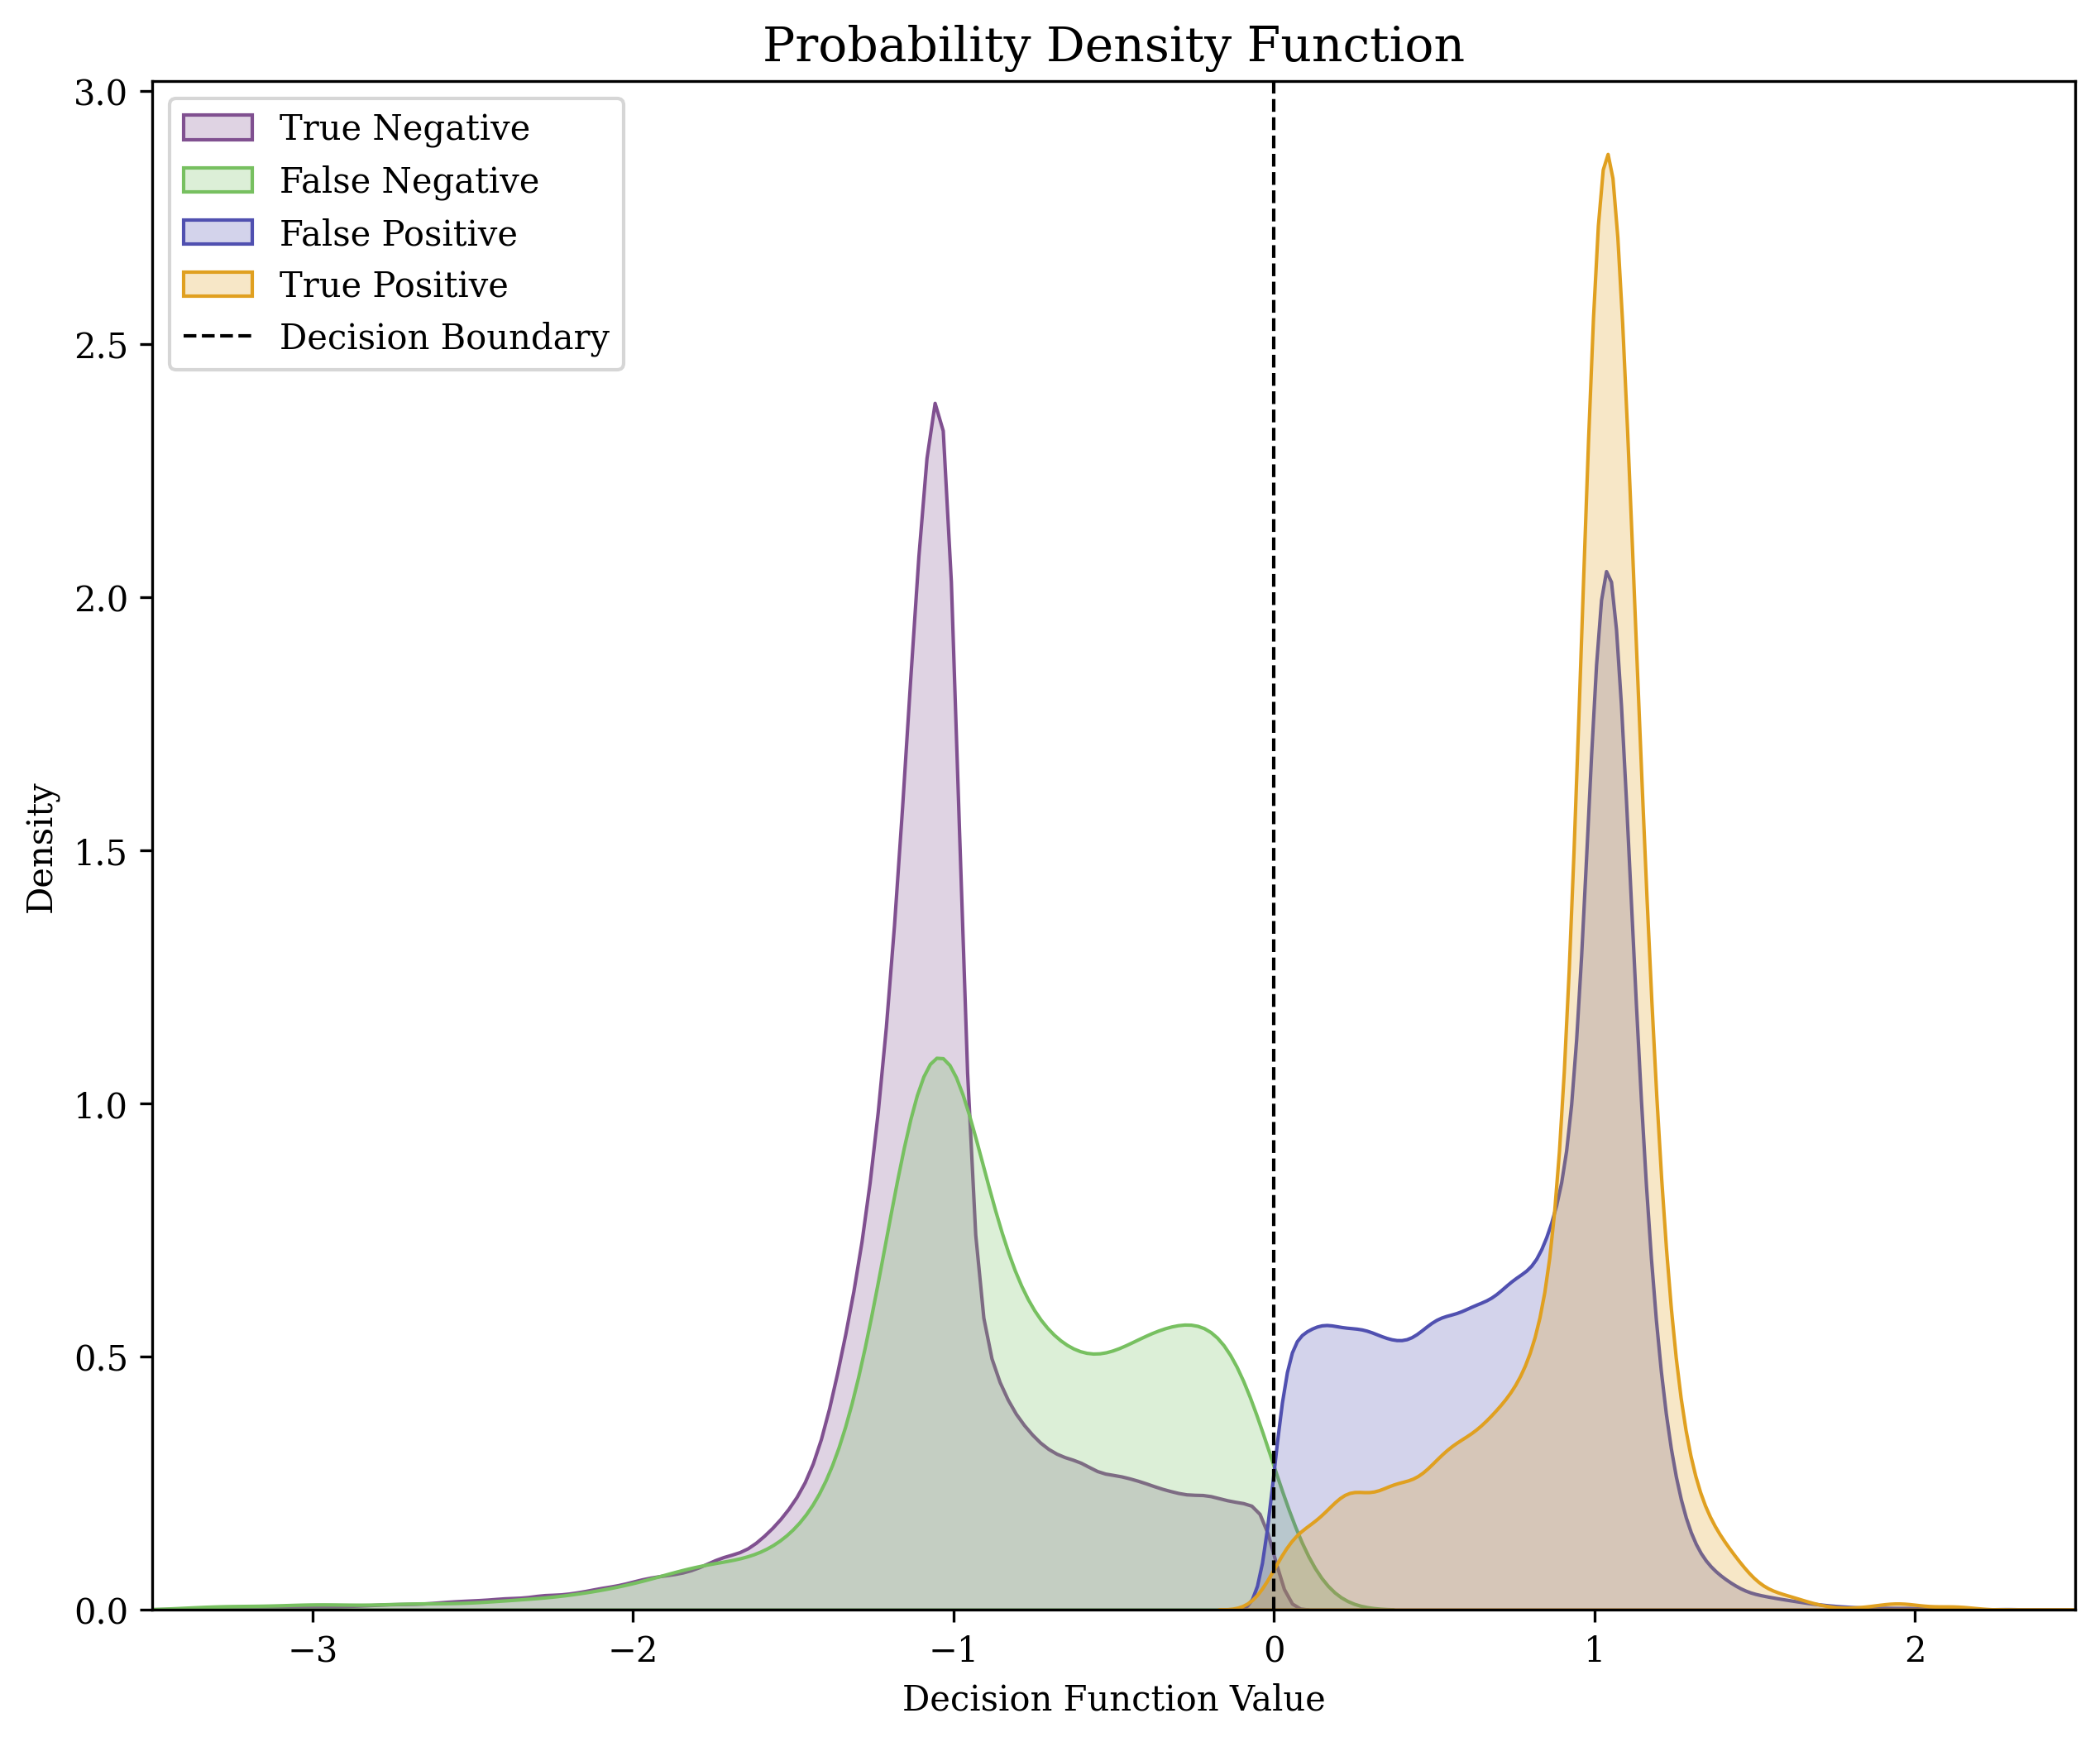

In [40]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.kdeplot(y_pred_prob_rbf[tn], label="True Negative", color='#805090', shade=True)
sns.kdeplot(y_pred_prob_rbf[fn], label="False Negative", color='#77C060', shade=True)
sns.kdeplot(y_pred_prob_rbf[fp], label="False Positive", color='#5050B0', shade=True)
sns.kdeplot(y_pred_prob_rbf[tp], label="True Positive", color='#E0A020', shade=True)

plt.xlim(-3.5, 2.5)
plt.axvline(0, color='black', linestyle='--', linewidth=1, label="Decision Boundary")
plt.xlabel("Decision Function Value")
plt.ylabel("Density")
plt.title("Probability Density Function")
plt.legend(loc="upper left")
plt.show()

In [50]:
from scipy.stats import gaussian_kde

kde_tp = gaussian_kde(y_pred_prob_rbf[tp])
kde_fp = gaussian_kde(y_pred_prob_rbf[fp])
x_vals = np.linspace(y_pred_prob_rbf.min(), y_pred_prob_rbf.max(), 1000)
x_limit = x_vals[(x_vals > 0.5) & (x_vals < 1.5)]
pdf_tp = kde_tp(x_limit)
pdf_fp = kde_fp(x_limit)

# Find intersection point
intersection_idx = np.argwhere(np.diff(np.sign(pdf_tp - pdf_fp))).flatten()
threshold = x_limit[intersection_idx[0]]
threshold = 0.6

tp_above_threshold = np.sum(y_pred_prob_rbf[tp] > threshold) / np.sum(tp)
print(f"{round(tp_above_threshold, 4)} of the True Positive data points are above the Decision Function value of {round(threshold, 4)}.")

y_pred_new = (y_pred_prob_rbf > threshold).astype(int)
print(np.sum(y_pred_new))

0.8574 of the True Positive data points are above the Decision Function value of 0.6.
56187


In [51]:
accuracy = accuracy_score(y_test, y_pred_new)
roc_auc = roc_auc_score(y_test, y_pred_new)

print(f"Accuracy: {round(accuracy, 4)}")
print(f"AUC-ROC Predict: {round(roc_auc, 4)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_new))

#### Is this good?

Accuracy: 0.8173
AUC-ROC Predict: 0.7402
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90    295679
           1       0.05      0.66      0.09      4321

    accuracy                           0.82    300000
   macro avg       0.52      0.74      0.50    300000
weighted avg       0.98      0.82      0.89    300000



In [ ]:
pred = y_pred_prob_poly > 0

tp = (y_test == 1) & (pred == True)    # Bad loan correctly classified
tn = (y_test == 0) & (pred == False)   # Good loan correctly classified
fp = (y_test == 0) & (pred == True)    # Good misclassified as Bad
fn = (y_test == 1) & (pred == False)   # Bad misclassified as Good

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Decision Boundary")

plt.scatter(np.where(tn)[0], y_pred_prob_poly[tn], color='#805090', label="True Negative", alpha=0.2, s=2)
plt.scatter(np.where(fn)[0], y_pred_prob_poly[fn], color='#77C060', label="False Negative", alpha=0.8, s=4)

plt.scatter(np.where(fp)[0], y_pred_prob_poly[fp], color='#5050B0', label="False Positive", alpha=0.2, s=2)
plt.scatter(np.where(tp)[0], y_pred_prob_poly[tp], color='#E0A020', label="True Positive", alpha=0.5, s=4)

plt.ylim(-5, 5)

plt.xlabel("Data Point Index")
plt.ylabel("Decision Function Value")
plt.title("Visualization of Classification Results - Poly Kernel SVM")
plt.legend(loc="upper left")
plt.show()

print(f"Number of True Positives (Bad loan correctly classified): {np.sum(tp)}")
print(f"Number of True Negatives (Good loan correctly classified): {np.sum(tn)}")
print(f"Number of False Positives (Good misclassified as Bad): {np.sum(fp)}")
print(f"Number of False Negatives (Bad misclassified as Good): {np.sum(fn)}")